# Shelter Animal Outcomes--Modeling

Use features like breed, color, sex, age, etc. to create models for predicting the adoption outcome for shelter animals to understand trends.

Every year, approximately 7.6 million companion animals end up in US shelters. Many animals are given up as unwanted by their owners, while others are picked up after getting lost or taken out of cruelty situations. Many of these animals find forever families to take them home, but just as many are not so lucky. 2.7 million dogs and cats are euthanized in the US every year.

### For Data Exploration, visit:

https://github.com/iamontheinet/datascience/blob/master/shelter_outcomes/notebooks/Shelter%20Animal%20Outcomes--Data%20Exploration.ipynb

### Load, Examine and Cleanup Data

* Convert outcome/target to 1 = Adoption, 0 = everything else
 *  This column has four values: euthanized, transfered, returned to owner, adopted
 *  Goal is to predict whether the pet will (remain) adopted or not
* Drop columns not needed for modeling
* Inspect columns with missing values
 *  Remove small fraction of samples with missing values while retaining ~99% of data
* Remove 22 rows with "0 years" as age
 *  Convert age from string to # of days
 *  The values are like so "1 month", "2 years", "4 days", "3 weeks" etc.
* Scale age
* One-hot code categorical features -- basically ALL the features except Age

### Modeling -- all features

##### Logistic Regression
* Accuracy and coefficients with train_test_split data

##### Decision Tree
* Find accuracy score based on train_test_split
* Create DecisionTreeClassifier based on the best max_depth observed 
* Plot decision tree
* Compute the feature importances

##### Random Forest with Cross-validation
* Compute cross-validation accuracy across 10 folds along with RandomForestClassifier
* Use GridSearchCV to automate the search for best *max_depth* per-tree
* Plot the results
* Examine the best model
* Use GridSearchCV to automate the search for *max_depth* and *min_samples_leaf*

### Modeling -- with select features
Two sets of top 5 features selected based on importances generated by LogisticRegression and DecisionTreeClassifier

* ***Logistic Regression***
* ***Decision Tree***
* ***Random Forest with Cross-validation***

In [11]:
#data handling/prediction
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.externals.six import StringIO
from sklearn import metrics
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier

#visualization
%matplotlib inline
import seaborn as sns
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz

### Load, Examine and Cleanup Data

### !!! It's ALL categorical !!!

In [12]:
# read data into a DataFrame
data = pd.read_csv("../data/data.csv")
print(data.dtypes)
print(data.shape)
data.head()

AnimalID          object
Name              object
DateTime          object
OutcomeType       object
OutcomeSubtype    object
AnimalType        object
SexuponOutcome    object
AgeuponOutcome    object
Breed             object
Color             object
dtype: object
(26729, 10)


AnimalID     Name             DateTime      OutcomeType OutcomeSubtype  \
0  A671945  Hambone  2014-02-12 18:22:00  Return_to_owner            NaN   
1  A656520    Emily  2013-10-13 12:44:00       Euthanasia      Suffering   
2  A686464   Pearce  2015-01-31 12:28:00         Adoption         Foster   
3  A683430      NaN  2014-07-11 19:09:00         Transfer        Partner   
4  A667013      NaN  2013-11-15 12:52:00         Transfer        Partner   

  AnimalType SexuponOutcome AgeuponOutcome                        Breed  \
0        Dog  Neutered Male         1 year        Shetland Sheepdog Mix   
1        Cat  Spayed Female         1 year       Domestic Shorthair Mix   
2        Dog  Neutered Male        2 years                 Pit Bull Mix   
3        Cat    Intact Male        3 weeks       Domestic Shorthair Mix   
4        Dog  Neutered Male        2 years  Lhasa Apso/Miniature Poodle   

         Color  
0  Brown/White  
1  Cream Tabby  
2   Blue/White  
3   Blue Cream  
4          Tan

In [13]:
clean_data = data
print("clean_data rows/cols before cleanup: ",clean_data.shape)

# Drop columns we don't need for modeling
del clean_data["Name"]
del clean_data["AnimalID"]
del clean_data["DateTime"]
del clean_data["OutcomeSubtype"]

('clean_data rows/cols before cleanup: ', (26729, 10))


In [14]:
# Convert outcome to 1 = Adoption, 0 = everything else
print(clean_data.OutcomeType.value_counts())
# clean_data.loc[:,('OutcomeType')] = (clean_data.OutcomeType=='Adoption').astype(int)
clean_data['OutcomeType'] = (clean_data.OutcomeType=='Adoption').astype(int)
print(clean_data.OutcomeType.value_counts())

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64
0    15960
1    10769
Name: OutcomeType, dtype: int64


In [15]:
# Inspect columns with missing values
print("Columns with missing values:")
print(clean_data.isnull().any())
# Check for # of missing values per column
print(clean_data.isnull().sum())

# Delete samples with missing values
clean_data_nonnull = clean_data.dropna()
print("Fraction of data kept:\n",float(clean_data_nonnull.shape[0])/clean_data.shape[0])
clean_data = clean_data_nonnull

Columns with missing values:
OutcomeType       False
AnimalType        False
SexuponOutcome     True
AgeuponOutcome     True
Breed             False
Color             False
dtype: bool
OutcomeType        0
AnimalType         0
SexuponOutcome     1
AgeuponOutcome    18
Breed              0
Color              0
dtype: int64
('Fraction of data kept:\n', 0.9992891615847955)


In [16]:
def convert_age_to_days(age):
    a,unit = age.split(" ")
    a = int(a)
    num_of_days = 0
    mult = 1
    if unit == "years" or unit == "year":
        mult = 365
    elif unit == "months" or unit == "month":
        mult = 30
    elif unit == "weeks" or unit == "week":
        mult = 7
        
    num_of_days = a * mult
    return num_of_days

In [17]:
# Remove 22 rows with "0 years" as age
clean_data = clean_data[clean_data.AgeuponOutcome != "0 years"]

# Convert age from string to number of days
clean_data.loc[:,['AgeuponOutcome']] = clean_data["AgeuponOutcome"].apply(convert_age_to_days)
# clean_data.AgeuponOutcome.value_counts().sort_values(ascending=False)

In [18]:
clean_age_data = clean_data.AgeuponOutcome.values.reshape(-1, 1)

# Scale clean_data.AgeuponOutcome
scaler = StandardScaler() #create a scaler object
scaler.fit_transform(clean_age_data) #fit the scaler
clean_age_data_scaled = scaler.transform(clean_age_data) #transform the data with it

# compare original to standardized
# print("original values:\n",clean_age_data[:10],"\n")
# print("scaled values:\n",clean_age_data_scaled[:10],"\n")

# figure out how the standardization worked
print("Mean of column:\n",scaler.mean_,"\n")
print("standard deviation of column:\n",scaler.scale_,"\n")
print("Final Means of scaled data:\n",clean_age_data_scaled.mean(axis=0))
print("Final standard deviation of scaled data:\n",clean_age_data_scaled.std(axis=0))

clean_data.loc[:,("AgeuponOutcome")] = clean_age_data_scaled

print("Age min value: ",clean_data.AgeuponOutcome.min())
print("Age min value: ",clean_data.AgeuponOutcome.max())

('Mean of column:\n', array([ 794.71942446]), '\n')
('standard deviation of column:\n', array([ 1082.98267468]), '\n')
('Final Means of scaled data:\n', array([ -1.95686792e-17]))
('Final standard deviation of scaled data:\n', array([ 1.]))
('Age min value: ', -0.73290131321242524)
('Age min value: ', 6.0068186939853723)


/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [19]:
# Extract sex from the same column that tells us whether animal was neutered, spayed, or left intact
def get_sex(val):
    if val.find('Male') >= 0: return 'Male'
    if val.find('Female') >= 0: return 'Female'
    return 'UnknownSex'

def get_neutered(val):
    if val.find('Spayed') >= 0: return 'Spayed'
    if val.find('Neutered') >= 0: return 'Neutered'
    if val.find('Intact') >= 0: return 'Intact'
    return 'UnknownNeuteredSpayed'

print("Before extraction:")
print(clean_data.SexuponOutcome.value_counts())
clean_data.loc[:,("Sex")] = clean_data.SexuponOutcome.apply(get_sex)
clean_data.loc[:,("NeuteredSpayed")] = clean_data.SexuponOutcome.apply(get_neutered)
print("After extraction: ")
print(clean_data.Sex.value_counts())

Before extraction:
Neutered Male    9779
Spayed Female    8819
Intact Male      3516
Intact Female    3498
Unknown          1076
Name: SexuponOutcome, dtype: int64
After extraction: 
Male          13295
Female        12317
UnknownSex     1076
Name: Sex, dtype: int64


/anaconda3/envs/py2/lib/python2.7/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [20]:
# One-hot code AnimalType - Dog or Cat
animal_type_one_coded = clean_data.AnimalType.str.get_dummies()

In [21]:
# One-hot code Sex
sex_upon_outcome_one_coded = clean_data.Sex.str.get_dummies()

In [22]:
# One-hot code Neutered, Spayed
neutered_spayed_one_coded = clean_data.NeuteredSpayed.str.get_dummies()

In [23]:
# One-hot code Color
# print(clean_data.Color.value_counts())
popular_colors = clean_data.Color.value_counts(ascending=False).head(5)
print("Top 5 colors: ",popular_colors)

def color_bucket(color):
    if color in popular_colors:
        return color
    
    return "OtherColor"

clean_data.loc[:,("Color")] = clean_data["Color"].apply(color_bucket)
color_one_coded = clean_data.Color.str.get_dummies()

('Top 5 colors: ', Black/White          2824
Black                2286
Brown Tabby          1628
Brown Tabby/White     939
White                 924
Name: Color, dtype: int64)


In [24]:
# One-hot code Breed
popular_breeds = clean_data.Breed.value_counts(ascending=False).head(5)
print("Top 5 breeds: ",popular_breeds)

def breed_bucket(breed):
    if breed in popular_breeds:
        return breed
    
    return "OtherBreed"

clean_data.loc[:,("Breed")] = clean_data["Breed"].apply(breed_bucket)
breed_one_coded = clean_data.Breed.str.get_dummies()

('Top 5 breeds: ', Domestic Shorthair Mix      8780
Pit Bull Mix                1906
Chihuahua Shorthair Mix     1766
Labrador Retriever Mix      1363
Domestic Medium Hair Mix     839
Name: Breed, dtype: int64)


In [25]:
# Merge one-hot coded dataframes with the original df
clean_data = clean_data.merge(animal_type_one_coded,left_index=True,right_index=True).merge(sex_upon_outcome_one_coded,left_index=True,right_index=True).merge(breed_one_coded,left_index=True,right_index=True).merge(color_one_coded,left_index=True,right_index=True).merge(neutered_spayed_one_coded,left_index=True,right_index=True)

# Drop original columns that aren't needed anymore
del clean_data["Breed"]
del clean_data["AnimalType"]
del clean_data["SexuponOutcome"]
del clean_data["Color"]
del clean_data["Sex"]
del clean_data["NeuteredSpayed"]

In [26]:
clean_data.columns = clean_data.columns.map(lambda x: x.replace(" ",""))
clean_data.columns = clean_data.columns.map(lambda x: x.replace("/",""))

In [27]:
clean_data.head()

OutcomeType  AgeuponOutcome  Cat  Dog  Female  Male  UnknownSex  \
0            0       -0.396793    0    1       0     1           0   
1            0       -0.396793    1    0       1     0           0   
2            1       -0.059760    0    1       0     1           0   
3            0       -0.714434    1    0       0     1           0   
4            0       -0.059760    0    1       0     1           0   

   ChihuahuaShorthairMix  DomesticMediumHairMix  DomesticShorthairMix  \
0                      0                      0                     0   
1                      0                      0                     1   
2                      0                      0                     0   
3                      0                      0                     1   
4                      0                      0                     0   

           ...            Black  BlackWhite  BrownTabby  BrownTabbyWhite  \
0          ...                0           0           0                0   
1          ...                0           0           0                0   
2          ...                0           0           0                0   
3          ...                0           0           0                0   
4          ...                0           0           0                0   

   OtherColor  White  Intact  Neutered  Spayed  UnknownNeuteredSpayed  
0           1      0       0         1       0                      0  
1           1      0       0         0       1                      0  
2           1      0       0         1       0                      0  
3           1      0       1         0       0                      0  
4           1      0       0         1       0                      0  

[5 rows x 23 columns]

#### Feature correlation matrix heatmaps for adopted vs not adopted pets

In [28]:
# Split data into (adopted vs not) and plot correlation matrix heatmaps 

adopted_data = pd.DataFrame(clean_data[clean_data.OutcomeType == 1])
not_adopted_data = pd.DataFrame(clean_data[clean_data.OutcomeType == 0])

adopted_data.drop(['OutcomeType'],inplace=True, axis=1)
not_adopted_data.drop(['OutcomeType'],inplace=True, axis=1)

#### Adoped pets

In [29]:
sns.mpl.pyplot.figure(figsize=(15, 12))
sns.heatmap(adopted_data.corr(),annot=True, fmt=".1f");

#### Not adopted pets

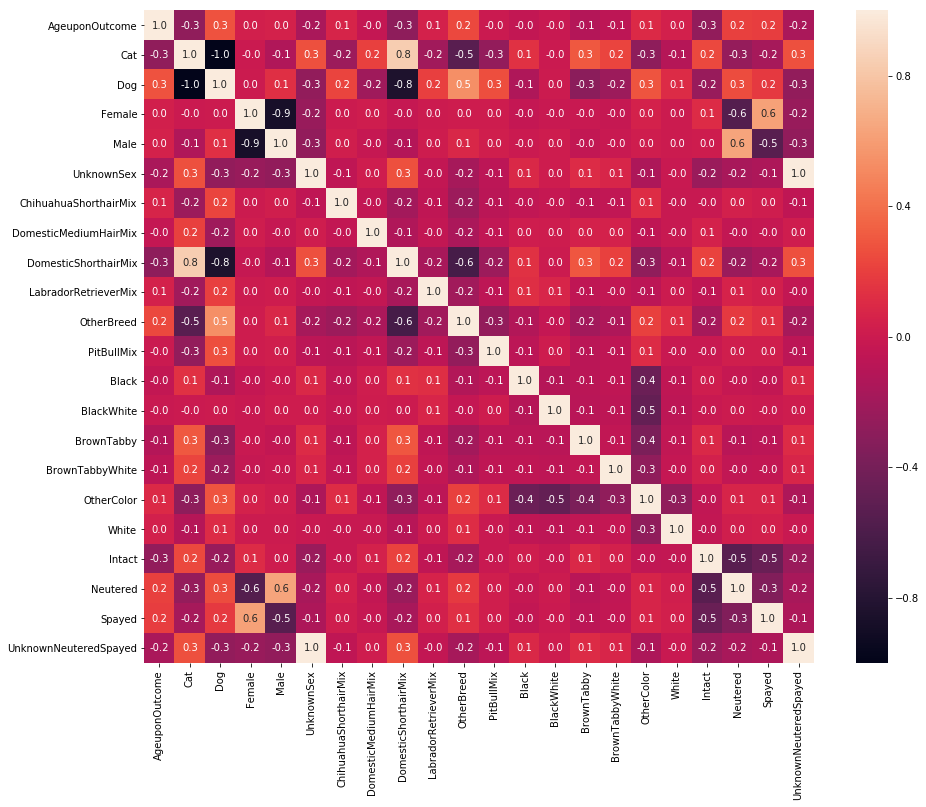

In [30]:
sns.mpl.pyplot.figure(figsize=(15, 12))
sns.heatmap(not_adopted_data.corr(),annot=True, fmt=".1f");

#### Examine split of adopted vs not

0    15919
1    10769
Name: OutcomeType, dtype: int64
0    0.596485
1    0.403515
Name: OutcomeType, dtype: float64


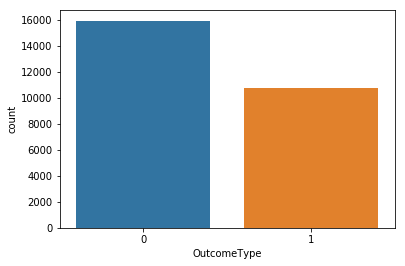

In [31]:
# Examine split of adopted vs not
print(clean_data.OutcomeType.value_counts())
print(clean_data.OutcomeType.value_counts()/clean_data.OutcomeType.value_counts().sum())

sns.countplot(clean_data.OutcomeType);

## Modeling -- All Features

### Logistic Regression (all features)

Accuracy and coefficients with splitting data

In [36]:
selected_features = clean_data.columns.tolist()[1:]
all_features_X = clean_data[selected_features]
all_y = clean_data.OutcomeType

all_X_train,all_X_test,all_y_train,all_y_test = train_test_split(all_features_X,all_y,random_state=42)

logreg_all = LogisticRegression(C=1e9)
logreg_all.fit(all_X_train,all_y_train)

dumb_model = DummyClassifier(strategy='most_frequent')
dumb_model.fit(all_X_train, all_y_train)
y_dumb_class = dumb_model.predict(all_X_test)

print("Bias coefficient (intercept): {0}".format(logreg_all.intercept_[0]))
print("Model accuracy on {0}% training data: {1}".format(int((1-n) * 100),metrics.accuracy_score(all_y_train,logreg_all.predict(all_X_train))))
all_y_test_pred = logreg_all.predict(all_X_test)
print("Model accuracy on {0}% test data: {1}".format(int(n * 100),metrics.accuracy_score(all_y_test,all_y_test_pred)))
print("Most frequent class dummy classifier test accuracy: ",metrics.accuracy_score(all_y_test, y_dumb_class))
print("F1 Score:\n", metrics.f1_score(all_y_test,all_y_test_pred))
print("\r") 
print("Features in order of their absolute coefficient values--indicating their importance")
feature_coeff_df = pd.DataFrame(list(zip(clean_data.columns.tolist()[1:],logreg_all.coef_[0],abs(logreg_all.coef_[0]))),columns=["feature","coefficient","abs_coefficient"])
print(feature_coeff_df.sort_values(['abs_coefficient'],ascending=False))

print("\n")

Bias coefficient (intercept): -1.47359566653
Model accuracy on 90% training data: 0.750099920064
Model accuracy on 10% test data: 0.732164268585
('Most frequent class dummy classifier test accuracy: ', 0.59892086330935257)
('F1 Score:\n', 0.69839662447257389)

Features in order of their absolute coefficient values--indicating their importance
                  feature  coefficient  abs_coefficient
5              UnknownSex    -3.700787         3.700787
21  UnknownNeuteredSpayed    -3.700787         3.700787
19               Neutered     1.998653         1.998653
20                 Spayed     1.953704         1.953704
18                 Intact    -1.725166         1.725166
3                  Female     1.251710         1.251710
2                     Dog    -1.041317         1.041317
4                    Male     0.975481         0.975481
0          AgeuponOutcome    -0.735849         0.735849
11             PitBullMix    -0.671628         0.671628
1                     Cat    -0.432279 

#### Notes: 
* Logistics Regression model accuracy: ~74%
* If bias coefficient (intercept) is positive, knowing nothing else means assume class 1. If negative, assume class 0. Since in this case it's negative, by default the animals are not getting adopted--which makes sense given the outcome (other vs adopted) split of 60/40. 
* Positive feature coefficients increase the log-odds of the response being 1 (and thus increase the probability), and negative feature coefficients decrease the log-odds of the response being 1 (and thus decrease the probability).
* In other words, negative feature coefficients forces outcome closer to 0; Positive feature coefficients forces outcome closer to 1.

### Decision Tree (all features)
Based on 70/30 train/test data split

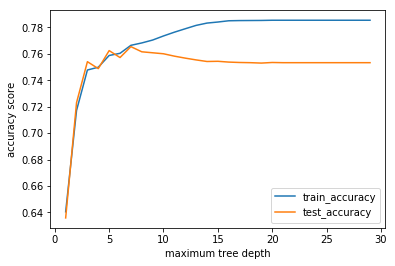

In [37]:
X_train,X_test,y_train,y_test = train_test_split(all_features_X,all_y,random_state=1)

depths = range(1,30)
train_accuracy, test_accuracy = [],[]
for depth in depths:
    decision_tree = DecisionTreeClassifier(max_depth=depth,random_state=10)
    decision_tree.fit(X_train,y_train)
    curr_train_accuracy = metrics.accuracy_score(y_train,decision_tree.predict(X_train))
    y_test_pred = decision_tree.predict(X_test)
    curr_test_accuracy = metrics.accuracy_score(y_test,y_test_pred)
    train_accuracy.append(curr_train_accuracy)
    test_accuracy.append(curr_test_accuracy)
#     print("F1 Score:\n", metrics.f1_score(y_test,y_test_pred))
    
sns.mpl.pyplot.plot(depths,train_accuracy,label='train_accuracy')
sns.mpl.pyplot.plot(depths,test_accuracy,label='test_accuracy')
sns.mpl.pyplot.xlabel("maximum tree depth")
sns.mpl.pyplot.ylabel("accuracy score")
sns.mpl.pyplot.legend();

In [38]:
#DecisionTreeClassifier based on the best max_depth = 6 observed above
best_single_tree = DecisionTreeClassifier(max_depth=6, random_state=1)
best_single_tree.fit(X_train,y_train)
best_single_tree_y_pred = best_single_tree.predict(X_test)
print("Best Decision Tree Accuracy Score:",metrics.accuracy_score(y_test,best_single_tree_y_pred))

dumb_model = DummyClassifier(strategy='most_frequent')
dumb_model.fit(X_train, y_train)
y_dumb_class = dumb_model.predict(X_test)
print("Most frequent class dummy classifier test accuracy: ",metrics.accuracy_score(y_test, y_dumb_class))
print("F1 Score: ", metrics.f1_score(y_test,best_single_tree_y_pred))

('Best Decision Tree Accuracy Score:', 0.7571942446043165)
('Most frequent class dummy classifier test accuracy: ', 0.60386690647482011)
('F1 Score: ', 0.66362126245847175)


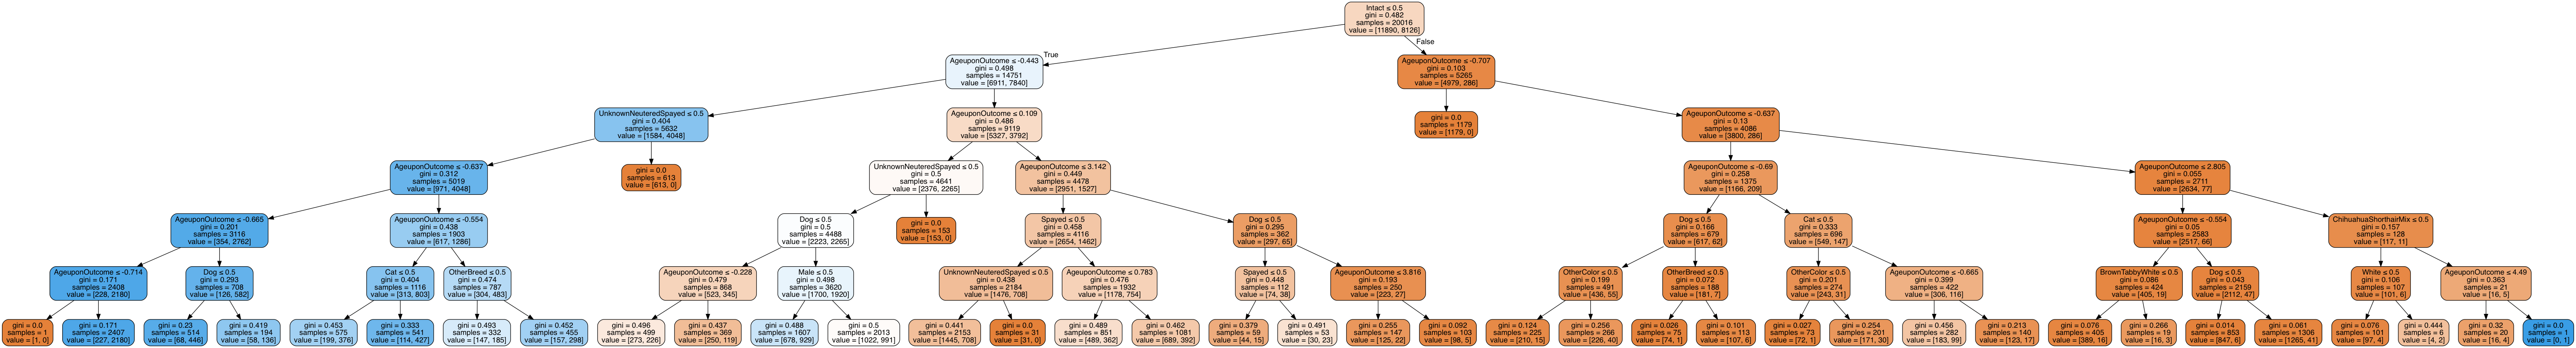

In [39]:
#Plot decision tree
dot_data = StringIO()  
export_graphviz(best_single_tree, out_file=dot_data,  
                    feature_names=X_train.columns.tolist(),  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

In [40]:
#Compute the feature importances
feature_imp = pd.DataFrame({'feature':X_train.columns.tolist(), 'importance':best_single_tree.feature_importances_})
print(feature_imp.sort_values("importance",ascending=False))

                  feature  importance
18                 Intact    0.489557
0          AgeuponOutcome    0.264234
21  UnknownNeuteredSpayed    0.219629
2                     Dog    0.011906
1                     Cat    0.005239
4                    Male    0.003645
20                 Spayed    0.002981
10             OtherBreed    0.001055
16             OtherColor    0.001019
6   ChihuahuaShorthairMix    0.000322
17                  White    0.000271
15        BrownTabbyWhite    0.000141
3                  Female    0.000000
19               Neutered    0.000000
12                  Black    0.000000
14             BrownTabby    0.000000
13             BlackWhite    0.000000
9    LabradorRetrieverMix    0.000000
8    DomesticShorthairMix    0.000000
7   DomesticMediumHairMix    0.000000
5              UnknownSex    0.000000
11             PitBullMix    0.000000


### Random Forest with Cross-validation (all features)

Compute cross-validation accuracy across 10 folds

In [41]:
rf = RandomForestClassifier(n_estimators=50) #random forest with 50 trees

# Compute cross-validation score accuracy across 10 folds
cross_val_scores = cross_val_score(rf,all_features_X,all_y,cv=10)
print("10-fold accuracies:\n",cross_val_scores)
print("Mean cv-accuracy:",np.mean(cross_val_scores))
print("Std of cv-accuracy:",np.std(cross_val_scores))

('10-fold accuracies:\n', array([ 0.7455976 ,  0.76508055,  0.75871113,  0.75758711,  0.74597227,
        0.75046834,  0.75046834,  0.76433121,  0.75159236,  0.76527934]))
('Mean cv-accuracy:', 0.75550882572799416)
('Std of cv-accuracy:', 0.0073131341136169542)


Use GridSearchCV to automate the search for best *max_depth* per-tree across 50 tress

('Best score:', 0.7641261990407674)
('Best params:', {'max_depth': 9})
('Best estimator:', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False))


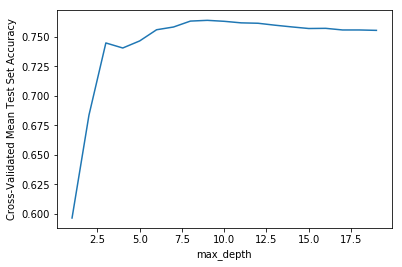

In [42]:
# Use GridSearchCV to automate the search to find best max_depth per-tree across depths 1-10
rf_grid = RandomForestClassifier(n_estimators=50,random_state=1,n_jobs=-1) #50 trees
max_depth_range = range(1, 20)
param_grid = dict(max_depth=max_depth_range)
grid = GridSearchCV(rf_grid, param_grid, cv=10, scoring='accuracy')
grid.fit(all_features_X, all_y)

# Examine the results of the grid search
# grid.cv_results_

grid_mean_scores = grid.cv_results_["mean_test_score"]

# Plot the results
sns.mpl.pyplot.plot(max_depth_range, grid_mean_scores)
sns.mpl.pyplot.xlabel('max_depth')
sns.mpl.pyplot.ylabel('Cross-Validated Mean Test Set Accuracy')

# Examine the best model
print("Best score:",grid.best_score_)
print("Best params:",grid.best_params_)
print("Best estimator:",grid.best_estimator_)

Use GridSearchCV to automate the search for multiple parameters (*max_depth* and *min_samples_leaf*) across 50 trees

#### Caution: This takes over ~10mins!

In [33]:
# Use GridSearchCV to automate the search for multiple parameters 
# (max_depth and min_samples_leaf) across 50 trees with depths range 1-10 and leaf samples range 1-8
rf_grid = RandomForestClassifier(n_estimators=50,random_state=1,n_jobs=-1) 
max_depth_range = range(1, 20)
leaf_range = range(1, 10)
param_grid2 = dict(max_depth=max_depth_range, min_samples_leaf=leaf_range)
grid2 = GridSearchCV(rf_grid, param_grid2, cv=10, scoring='accuracy')
grid2.fit(all_features_X, all_y)

print("Best GridSearchCV score:",grid2.best_score_)
print("Best GridSearchCV params:",grid2.best_params_)

('Best GridSearchCV score:', 0.76450089928057552)
('Best GridSearchCV params:', {'max_depth': 9, 'min_samples_leaf': 9})


## Modeling -- Select Features

**Two sets of top 5 features selected based on importance generated by Logistic Regression and DecisionTreeClassifier**

In [191]:
print("Top 5 features based on importance generated by LogisticRegression:",
      feature_coeff_df.sort_values(['abs_coefficient'],ascending=False).head(5))

print("Top 5 features based on importance generated by DecisionTreeClassifier:",
      feature_imp.sort_values("importance",ascending=False).head(5))

selected_features_logit = feature_coeff_df.sort_values(['abs_coefficient'],ascending=False).head(5).loc[:,'feature'].tolist()
selected_features_dtree = feature_imp.sort_values("importance",ascending=False).head(5).loc[:,'feature'].tolist()

select_features_logit_X = clean_data[selected_features_logit]
select_features_dtree_X = clean_data[selected_features_dtree]

all_y = clean_data.OutcomeType

('Top 5 features based on importance generated by LogisticRegression:',                  feature  coefficient  abs_coefficient
0  UnknownNeuteredSpayed    -3.946955         3.946955
1             UnknownSex    -3.946955         3.946955
2                 Spayed     1.953868         1.953868
3               Neutered     1.722872         1.722872
4                 Intact    -1.318669         1.318669)
('Top 5 features based on importance generated by DecisionTreeClassifier:',                   feature  importance
18                 Intact    0.489392
0          AgeuponOutcome    0.269789
21  UnknownNeuteredSpayed    0.216950
2                     Dog    0.013665
1                     Cat    0.005304)


Correlation matrix for top 5 features based on Logit


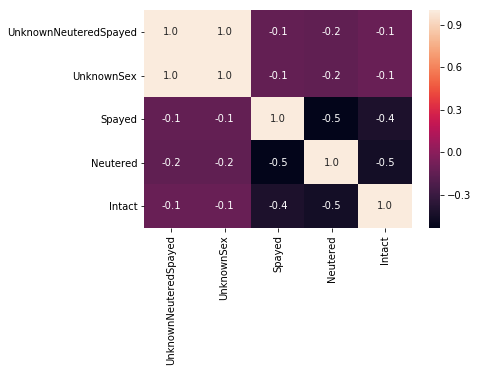

In [242]:
print("Correlation matrix for top 5 features based on Logit")
sns.heatmap(select_features_logit_X.corr(),annot=True, fmt=".1f");

Correlation matrix for top 5 features based on DTree


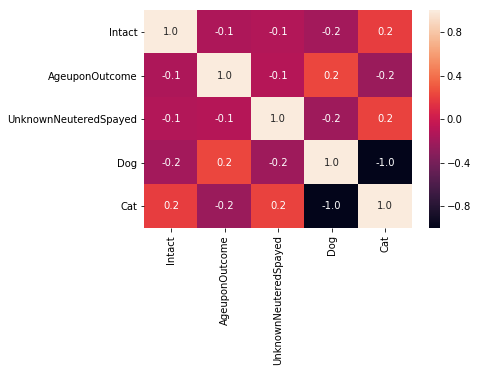

In [243]:
print("Correlation matrix for top 5 features based on DTree")
sns.heatmap(select_features_dtree_X.corr(),annot=True, fmt=".1f");

### Logistic Regression (select features)

In [199]:
def logistic_regression(features_X,features_list,features_source):
    for n in [0.3,0.2,0.1]:
        all_X_train,all_X_test,all_y_train,all_y_test = train_test_split(features_X,all_y,test_size=n,random_state=1)

        logreg_all = LogisticRegression(C=1e9)
        logreg_all.fit(all_X_train,all_y_train)

        print("========== Data split {0}/{1} with select features based on {2}".format(int((1-n) * 100),int(n * 100),features_source))
        print("Bias coefficient (intercept): {0}".format(logreg_all.intercept_[0]))
        print("Model accuracy on {0}% training data: {1}".format(int((1-n) * 100),metrics.accuracy_score(all_y_train,logreg_all.predict(all_X_train))))
        print("Model accuracy on {0}% test data: {1}".format(int(n * 100),metrics.accuracy_score(all_y_test,logreg_all.predict(all_X_test))))
        print("\r") 
        print("Features in order of their absolute coefficient values--indicating their importance")
        feature_coeff_df = pd.DataFrame(list(zip(features_list,logreg_all.coef_[0],abs(logreg_all.coef_[0]))),columns=["feature","coefficient","abs_coefficient"])
        print(feature_coeff_df.sort_values(['abs_coefficient'],ascending=False))
        print("\n")
        
print("########## Accuracy based on select features from Logit ##########")
logistic_regression(select_features_logit_X,selected_features_logit,"Logit")
print("########## Accuracy based on select Features from Dtree ##########")
logistic_regression(select_features_dtree_X,selected_features_dtree,"DTree")

########## Accuracy based on select features from Logit ##########
========== Data split 70/30 with select features based on Logit
Bias coefficient (intercept): -1.57729912
Model accuracy on 70% training data: 0.681548096997
Model accuracy on 30% test data: 0.675034344948

Features in order of their absolute coefficient values--indicating their importance
                 feature  coefficient  abs_coefficient
0  UnknownNeuteredSpayed    -3.959457         3.959457
1             UnknownSex    -3.959457         3.959457
2                 Spayed     1.945543         1.945543
3               Neutered     1.728286         1.728286
4                 Intact    -1.291671         1.291671


========== Data split 80/20 with select features based on Logit
Bias coefficient (intercept): -1.58038078612
Model accuracy on 80% training data: 0.680655737705
Model accuracy on 20% test data: 0.67534657175

Features in order of their absolute coefficient values--indicating their importance
                 

#### Notes:
* ##### For selected features based on importances from Logistic Regression
 * Logit model accuracy: ~67%
 * Bias coefficient (intercept): -1.58; means knowing nothing == assume class 0 == assume animals do not get adopted
 
* ##### For selected features based on importances from Decision Tree
 * Logit model accuracy: ~74%
 * Bias coefficient (intercept): 0.26; means knowing nothing == assume class 1 == assume animals get adopted

For both:

* Positive feature coefficients increase the log-odds of the response being 1 (and thus increase the probability), and negative feature coefficients decrease the log-odds of the response being 1 (and thus decrease the probability).
* In other words, negative feature coefficients forces outcome closer to 0; Positive feature coefficients forces outcome closer to 1.

### Decision Tree (select features)

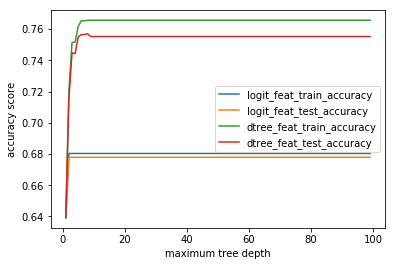

In [245]:
def decision_tree(features_X,features_source):
    X_train,X_test,y_train,y_test = train_test_split(features_X,all_y,test_size=.3,random_state=123)

    depths = range(1,100)
    train_accuracy, test_accuracy = [],[]
    for depth in depths:
        decision_tree = DecisionTreeClassifier(max_depth=depth,random_state=10)
        decision_tree.fit(X_train,y_train)
        curr_train_accuracy = metrics.accuracy_score(y_train,decision_tree.predict(X_train))
        curr_test_accuracy = metrics.accuracy_score(y_test,decision_tree.predict(X_test))
#         print(features_source + " -- decision Tree Train/Test accuracy for depth "+str(depth),curr_train_accuracy," ",curr_test_accuracy)
        train_accuracy.append(curr_train_accuracy)
        test_accuracy.append(curr_test_accuracy)
    sns.mpl.pyplot.plot(depths,train_accuracy,label=features_source+'_train_accuracy')
    sns.mpl.pyplot.plot(depths,test_accuracy,label=features_source+'_test_accuracy')
    sns.mpl.pyplot.xlabel("maximum tree depth")
    sns.mpl.pyplot.ylabel("accuracy score")
    sns.mpl.pyplot.legend();

decision_tree(select_features_logit_X,"logit_feat")
decision_tree(select_features_dtree_X,"dtree_feat")

In [246]:
#DecisionTreeClassifier based on the best max_depth = 8 observed from 10 trials
best_single_tree = DecisionTreeClassifier(max_depth=8, random_state=1)
best_single_tree.fit(X_train,y_train)
print("Best Decision Tree Accuracy Score:",metrics.accuracy_score(y_test,best_single_tree.predict(X_test)))

('Best Decision Tree Accuracy Score:', 0.76070937929311855)


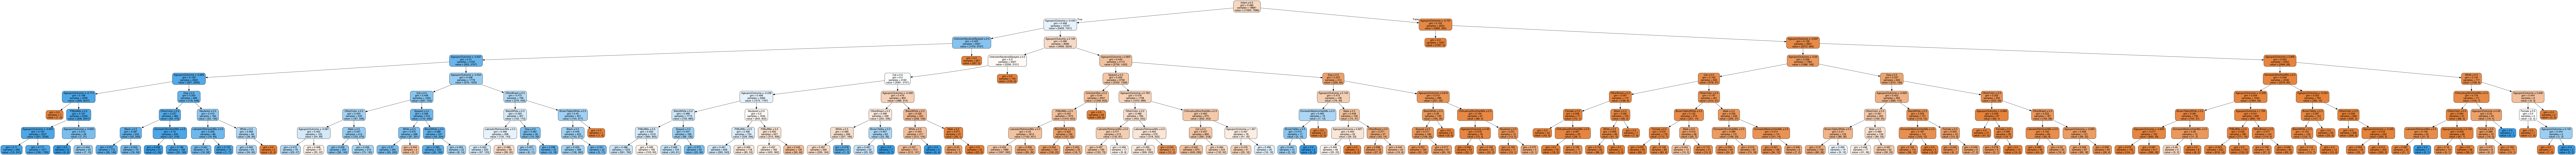

In [247]:
#Plot decision tree
dot_data = StringIO()  
export_graphviz(best_single_tree, out_file=dot_data,  
                    feature_names=X_train.columns.tolist(),  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

#### Notes:
* Best Decision Tree Accuracy Score: ~76%

### Random Forest with Cross-validation (select features)

In [220]:
def random_forest(features_X):    
    rf = RandomForestClassifier(n_estimators=50) #random forest with 50 trees

    # Compute cross-validation score accuracy across 10 folds
    cross_val_scores = cross_val_score(rf,features_X,all_y,cv=10)
    print("10-fold accuracies:\n",cross_val_scores)
    print("Mean cv-accuracy:",np.mean(cross_val_scores))
    print("Std of cv-accuracy:",np.std(cross_val_scores))
    
print("########## Accuracy based on select features from Logit ##########")
random_forest(select_features_logit_X)
print("########## Accuracy based on select Features from Dtree ##########")
random_forest(select_features_dtree_X)

########## Accuracy based on select features from Logit ##########
('10-fold accuracies:\n', array([ 0.67403522,  0.67440989,  0.66466842,  0.68302735,  0.68602473,
        0.68302735,  0.68077932,  0.69726489,  0.67141251,  0.68128984]))
('Mean cv-accuracy:', 0.67959395202988149)
('Std of cv-accuracy:', 0.0085378932073141758)
########## Accuracy based on select Features from Dtree ##########
('10-fold accuracies:\n', array([ 0.749719  ,  0.77032596,  0.76732859,  0.75946047,  0.75458973,
        0.7590858 ,  0.7590858 ,  0.77219933,  0.76208318,  0.76752906]))
('Mean cv-accuracy:', 0.76214069157428754)
('Std of cv-accuracy:', 0.0067918383129425258)


#### Notes:
* ##### Model accuracy for selected features based on importances from Logistic Regression: ~68%
* ##### Model accuracy for selected features based on importances from Decision Tree: ~76%

Use GridSearchCV to automate the search for *max_depth* across 50 trees

#### Caution: This takes over ~5mins!

In [226]:
def grid_search_cv_max_depth(features_X):
    # Use GridSearchCV to automate the search to find best max_depth per-tree across depths 1-10
    rf_grid = RandomForestClassifier(n_estimators=50,random_state=1,n_jobs=-1) #50 trees
    max_depth_range = range(5, 20)
    param_grid = dict(max_depth=max_depth_range)
    grid = GridSearchCV(rf_grid, param_grid, cv=10, scoring='accuracy')
    grid.fit(features_X, all_y)

    # Examine the results of the grid search
    # grid.cv_results_

    grid_mean_scores = grid.cv_results_["mean_test_score"]

    # Plot the results
#     sns.mpl.pyplot.plot(max_depth_range, grid_mean_scores)
#     sns.mpl.pyplot.xlabel('max_depth')
#     sns.mpl.pyplot.ylabel('Cross-Validated Mean Test Set Accuracy')

    # Examine the best model
    print("Best score:",grid.best_score_)
    print("Best params:",grid.best_params_)
    print("Best estimator:",grid.best_estimator_)

print("########## Best params based on select features from Logit ##########")
grid_search_cv_max_depth(select_features_logit_X)
print("########## Best params based on select Features from Dtree ##########")
grid_search_cv_max_depth(select_features_dtree_X)

########## Best params based on select features from Logit ##########
('Best score:', 0.67959382494004794)
('Best params:', {'max_depth': 5})
('Best estimator:', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False))
########## Best params based on select Features from Dtree ##########
('Best score:', 0.76270233812949639)
('Best params:', {'max_depth': 9})
('Best estimator:', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
           

#### Notes:
* ##### Best GridSearchCV (max_depth) score for selected features based on importances from Logistic Regression: ~67%
* ##### Best GridSearchCV (max_depth) score for selected features based on importances from Decision Tree: ~76%

Use GridSearchCV to automate the search for multiple parameters (*max_depth* and *min_samples_leaf*) across 50 trees

#### Caution: This takes over ~15mins!

In [227]:
def grid_search_cv_maxdepth_minsamples(features_X):
    # Use GridSearchCV to automate the search for multiple parameters 
    # (max_depth and min_samples_leaf) across 50 trees with depths range 1-10 and leaf samples range 1-8
    rf_grid = RandomForestClassifier(n_estimators=50,random_state=1,n_jobs=-1) 
    max_depth_range = range(5, 20)
    leaf_range = range(1, 8)
    param_grid2 = dict(max_depth=max_depth_range, min_samples_leaf=leaf_range)
    grid2 = GridSearchCV(rf_grid, param_grid2, cv=10, scoring='accuracy')
    grid2.fit(features_X, all_y)

    print("Best GridSearchCV score:",grid2.best_score_)
    print("Best GridSearchCV params:",grid2.best_params_)
    
print("########## Best params based on select features from Logit ##########")
grid_search_cv_maxdepth_minsamples(select_features_logit_X)
print("########## Best params based on select Features from Dtree ##########")
grid_search_cv_maxdepth_minsamples(select_features_dtree_X)

########## Best params based on select features from Logit ##########
('Best GridSearchCV score:', 0.67959382494004794)
('Best GridSearchCV params:', {'max_depth': 5, 'min_samples_leaf': 1})
########## Best params based on select Features from Dtree ##########
('Best GridSearchCV score:', 0.762777278177458)
('Best GridSearchCV params:', {'max_depth': 9, 'min_samples_leaf': 2})


#### Notes:
* ##### Best GridSearchCV score for selected features based on importances from Logistic Regression: ~67%
* ##### Best GridSearchCV score for selected features based on importances from Decision Tree: ~76%

## Summary

* When including all features, the accuracy observed using logistic regression, decision tree and random forest is within ~%2.
* Logistic regression and decision tree both take way less time compared to Random Forest with cross-validation and GridSearchCV
* When including only the top (5) features, the accuracy observed based on feature importances generated by decision tree is much better compared to accuracy based on important features generated by logistic regression.
* F1 score is less than accuracy score for all models.

## Next Steps

* Modularize and consolidate code using functions and pipelines
* Generate ROC and AUC